In [118]:
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pickle as pkl

from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)


import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [119]:

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
    iss_test: np.ndarray
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        # max_depth=5,
        # reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_true_train)
        
    y_pred = xgb_model.predict(x_test[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    auroc = metrics.roc_auc_score(y_true_test, y_pred)

    
    print("===================")
    print("%s - training auroc %s"%(method, metrics.roc_auc_score(y_true_train, xgb_model.predict(x_train[:, features]))))
    print("%s - testing auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

def feature_idx(
    method: str,
    cohort: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_xlearner.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_xlearner.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_xlearner.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    indices  = [ x.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    
    for i in indices:
        if i > treatment_index:
            i -= 1
        
    return indices

In [124]:
ist3 = pd.read_sas("../data/datashare_aug2015.sas7bdat")

continuous_vars = [
                    "gender",
                    "age",
                    "weight",
                    "glucose",
                    "gcs_eye_rand",
                    "gcs_motor_rand",
                    "gcs_verbal_rand",
                    # "gcs_score_rand",   
                     "nihss" ,
                     "sbprand",
                     "dbprand",
                     "antiplat_rand"
                  ]

cate_variables = [
                     # "livealone_rand",
                     # "indepinadl_rand",
                     "infarct",
                     # "atrialfib_rand",
                    #  "liftarms_rand",
                    # "ablewalk_rand",
                    # "weakface_rand",
                    # "weakarm_rand",
                    # "weakleg_rand",
                    # "dysphasia_rand",
                    # "hemianopia_rand",
                    # "visuospat_rand",
                    # "brainstemsigns_rand",
                    # "otherdeficit_rand",
                    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

x = ist3[continuous_vars + cate_variables + treatment]

x = pd.get_dummies(x, columns=cate_variables)

n, feature_size = x.shape


names = x.drop(["itt_treat"], axis=1).columns
treatment_index = x.columns.get_loc("itt_treat")

x.iloc[:, treatment_index] = np.where(x["antiplat_rand"]== 2, 0, 1)

var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=1,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=1,
                                    )


w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:, var_index]
x_test = x_test[:, var_index]

y_train = y_train ==0
y_test = y_test == 0

In [125]:
results_train = pickle.load(open("../results/ist3/train_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/ist3/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

# threshold_train = np.mean(results_train, axis=1).reshape(-1,1)
# thresohld_test = np.mean(results_test, axis=1).reshape(-1,1)

# y_true_train = np.where(np.mean((results_train > threshold_train), axis=0) > 0.5, 1, 0 )
# y_true_test = np.where(np.mean((results_test > thresohld_test), axis=0) > 0.5, 1, 0 )


estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

threshold = np.mean(estimated_ate_train, )

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

explainers = {
    "shap": feature_idx("shap","ist3"), #[gender,trauma ,cause_cut, edgcs, cause_mv ]
    "shap - 0 ": feature_idx("shap - 0 ","ist3" ), #[temp, ph, bd, hgb, trauma ]
    "ig": feature_idx("ig","ist3" ), #[ph, na, temp, gender, trauma ],
    
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        None
    )

0.00034098832191667785 0.0020073798551291915
-0.0006228304731612028 0.0037063818911778363
['infarct_0.0', 'stroketype_1.0', 'stroketype_2.0', 'infarct_1.0', 'infarct_2.0']
['gcs_eye_rand', 'gcs_motor_rand', 'sbprand', 'gcs_verbal_rand', 'dbprand']
['gcs_motor_rand', 'gcs_eye_rand', 'gcs_verbal_rand', 'sbprand', 'dbprand']
shap - training auroc 0.5315717110679217
shap - testing auroc 0.5376524390243903
shap - ATE 0.0001357826975897673
shap - 0  - training auroc 0.8038649885000891
shap - 0  - testing auroc 0.47082425958188157
shap - 0  - ATE -0.001007189082106057
ig - training auroc 0.8048155346397684
ig - testing auroc 0.4998475609756098
ig - ATE -0.0002498566204853835
full features - training auroc 0.9876386566746161
full features - testing auroc 0.5133710801393727
full features - ATE -0.000742726960649815
random features - training auroc 0.6727225084233666
random features - testing auroc 0.49208950348432057
random features - ATE -0.0002506914482409014


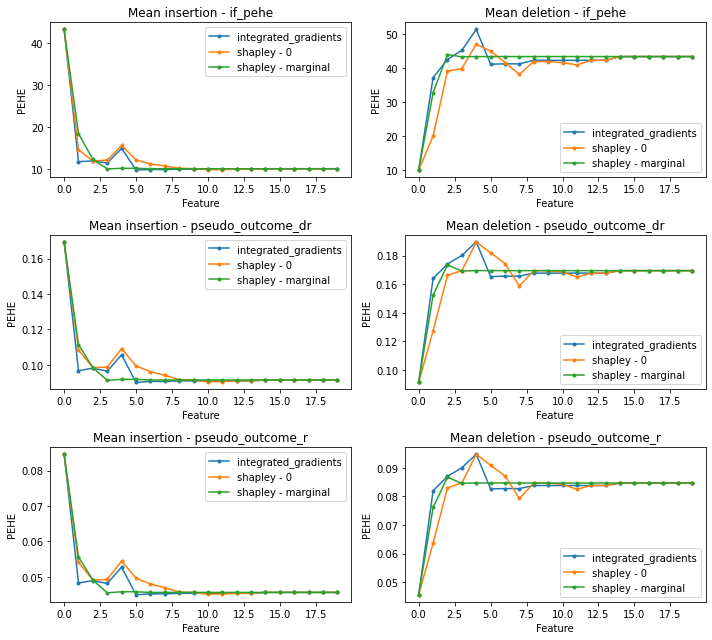

In [64]:
explainers = [
    "integrated_gradients", 
    "shapley_value_sampling",
    "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

# Loop over the different files
for file_num in range(10):  # assuming there are 5 files, from 0 to 4
    
    if file_num not in [1]:
        
        for selection_type in selection_types:
            file_path = f"../results/ist3/insertion_deletion_xlearner_{file_num}.pkl"
            results = pkl.load(open(file_path,'rb'))

            for exp_index, exp in enumerate(explainers):
                insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
                deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))

fig, axs = plt.subplots(len(selection_types), 2, figsize=(10, 3*len(selection_types)))

# Calculate and plot mean results

for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        
        if exp == "shapley_value_sampling":
            label = "shapley - 0"
        elif exp == "naive_shap":
            label = "shapley - marginal"
        else:
            label = exp
            
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)

        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)

        features_num = len(insertion_results_mean)

        axs[i, 0].plot([j for j in range(features_num)],
                 insertion_results_mean,
                 '-o',
                 markersize=3,
                 label=f'{label}')

        axs[i, 0].set_title(f"Mean insertion - {selection_type}")
        axs[i, 0].set_xlabel('Feature')
        axs[i, 0].set_ylabel('PEHE')

        axs[i, 1].plot([j for j in range(features_num)],
                 deletion_results_mean,
                 '-o',
                 markersize=3,
                 label=f'{label}')
        

        axs[i, 1].set_title(f"Mean deletion - {selection_type}")
        axs[i, 1].set_xlabel('Feature')
        axs[i, 1].set_ylabel('PEHE')
        
        axs[i, 0].legend(loc='upper right')
        axs[i, 1].legend(loc='lower right')
        
plt.tight_layout()
plt.show()